# Tutorial 2 - Inferring Protein Activity from scRNA-seq data from multiple cell populations with the meta-VIPER approach

This tutorial explores the use of metaVIPER to assess protein activity by integrative analysis using multiple gene regulatory networks. metaVIPER is particularly useful in real-world scenarios to infer protein activity in a tissue-independent manner by using multiple, non-tissue-matched interactomes, assuming that transcriptional targets of each protein can be recapitulated by one or more available interactomes. The `viper` function allows running metaVIPER using both [aREA](https://www.nature.com/articles/ng.3593) and [NaRnEA](https://www.mdpi.com/1099-4300/25/3/542) enrichment methods. For additional details, please refer to [Ding et al., 2016](https://www.nature.com/articles/s41467-018-03843-3).

<code style="background:lightgreen;color:black">Add part on enrichment.</code>


### Install Pyviper
Install `pyviper` from PyPI using pip. Alternatively, refer to the README in the current GitHub to install from the local directory.

In [122]:
# !pip install pyviper

### Import modules

In [123]:
import pyther
import scanpy as sc
import anndata 
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore", message=".*The 'nopython' keyword.*") # for jit decorator issue with sc.pp.neighbors (09/30/2023)

### Step 1. Load a gene expression matrix and associated metadata  
Load the gene expression matrix (UMIs) and store it into an [AnnData](https://anndata.readthedocs.io/en/latest/) object to enable interoperability with [scanpy](https://scanpy-tutorials.readthedocs.io/en/latest/#). Cells used in this tutorial were sampled from scRNA-seq data published in [Peng et al., 2019](https://www.nature.com/articles/s41422-019-0195-y).  

In [124]:
# gExpr_path = "/Users/lucazanella7/Desktop/ColumbiaProjects/pyther_test_data/subset_Peng/T11_subset.tsv"  # where gene expression matrix (UMI counts) is located
gExpr_path = "/Users/lucazanella7/Desktop/ColumbiaProjects/pyther_test_data/subset_Peng/d1_d2_f_subset_6500.tsv" # path to gene expression matrix (UMI counts)
adata_gExpr = sc.read(gExpr_path).T

Display matrix dimensions (cells x genes)

In [125]:
adata_gExpr

AnnData object with n_obs × n_vars = 6500 × 24005

Load cell-associated metadata

In [126]:
#metadata_path = "/Users/lucazanella7/Desktop/ColumbiaProjects/pyther_test_data/subset_Peng/T11_metadata.tsv"  # where cells metadata are located
metadata_path = "/Users/lucazanella7/Desktop/ColumbiaProjects/pyther_test_data/subset_Peng/d1_d2_f_metadata_6500.tsv" # path to cells metadata
cells_metadata = pd.read_csv(metadata_path, sep="\t")  # load it

Store the metadata in the `adata_gExpr` object as observation annotation.

In [127]:
adata_gExpr.obs = pd.merge(adata_gExpr.obs, cells_metadata, how="left",left_index=True, right_index=True) # store cell-specific metadata as annotation observation

Display the observation annotation from the AnnData object.

In [128]:
adata_gExpr.obs.head()

,Patient,Cell_Type
T1_AAACCTGAGATGTCGG,T1,Fibroblast cell
T1_AACACGTCAATGACCT,T1,Ductal cell type 2
T1_AACCATGTCTGTCCGT,T1,Ductal cell type 2
T1_AACCGCGTCGAATGGG,T1,Ductal cell type 2
T1_AACGTTGCAATGGATA,T1,Stellate cell


The observation annotations include the patient from which each cell was sequenced and the annotated cell type.
List the cell types.

In [129]:
adata_gExpr.obs.groupby('Cell_Type').size().reset_index(name='n') # show cell types and number of cells for each type in AnnData

,Cell_Type,n
0,Ductal cell type 1,690
1,Ductal cell type 2,2938
2,Fibroblast cell,1477
3,Stellate cell,1395


Data contain <span style="color:red">4</span> cells types: Ductal cells of type 1 and 2 (non-transformed and malignant, respectively), Fibroblasts and Stellate cells (myofibroblast-like cells).

### Step 2. Preprocess and generate a gene expression signature at the single-cell level

The UMI matrix can be processed using the standard `Scanpy` preprocessing workflow. Since the quality of the provided data was pre-assessed and found to be high, cell filtering will be minimal. For a more detailed explanation of QC steps, refer to the preprocessing tutorials bt [Scanpy](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html) or [Seurat](https://satijalab.org/seurat/articles/pbmc3k_tutorial). 

In [130]:
sc.pp.filter_cells(adata_gExpr, min_genes=200) # filter out cells with <200 genes expressed
sc.pp.filter_genes(adata_gExpr, min_cells=3) # filter out genes that are detected in <3 cells

Display matrix dimensions post-filtering (cells x genes) 

In [131]:
adata_gExpr

AnnData object with n_obs × n_vars = 6500 × 20931
    obs: 'Patient', 'Cell_Type', 'n_genes'
    var: 'n_cells'

Normalize the gene expression matrix by the total number of UMIs to 10,000 UMIs per cells to make each gene expression comparable across cells and log-transform the normalized counts. Then, store the log-normalized counts in the `.raw` attribute of the `AnnData` object

In [132]:
sc.pp.normalize_total(adata_gExpr, target_sum=1e4) # normalize counts
sc.pp.log1p(adata_gExpr) # log-transform the counts
sc.pp.calculate_qc_metrics(adata_gExpr, percent_top=None, log1p=False, inplace=True) # compute some statistics, e.g. total_counts, n_cells_by_counts etc 

adata_gExpr.raw = adata_gExpr   # store log-normalized counts to .raw Attribute for potential future use

Generate a gene expression signature on a single-cell basis by scaling each gene to unit variance. This scaled matrix will be used as an input to `pyther` to compute the protein activity matrix. Several approaches exist for the purpose, including computing a reference with respect to an external reference or using models such as [SCTransform](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-019-1874-1). We will employ the simplest approach for demonstrative purposes. 

In [133]:
sc.pp.regress_out(adata_gExpr, 'total_counts') # regress out the effect of the total number of UMIs
sc.pp.scale(adata_gExpr, max_value=10) # standardize gene expression and clip max values to 10

In [134]:
adata_gExpr

AnnData object with n_obs × n_vars = 6500 × 20931
    obs: 'Patient', 'Cell_Type', 'n_genes', 'n_genes_by_counts', 'total_counts'
    var: 'n_cells', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'mean', 'std'
    uns: 'log1p'

Display a chunk of the scaled matrix (signature)

In [135]:
adata_gExpr[1:5,1:7].to_df()

,AP006222.2,RP11-206L10.3,RP11-206L10.2,RP11-206L10.9,LINC00115,FAM41C
T1_AACACGTCAATGACCT,-0.366852,-0.107912,-0.064235,-0.081443,-0.186370,-0.112861
T1_AACCATGTCTGTCCGT,-0.320497,-0.086591,-0.066305,-0.071187,-0.147921,-0.067329
T1_AACCGCGTCGAATGGG,-0.306291,-0.080056,-0.066939,-0.068043,-0.136138,-0.053375
T1_AACGTTGCAATGGATA,-0.315497,-0.084291,-0.066528,-0.070080,-0.143774,-0.062418


### Step 3. Load multiple ARACNe-inferred gene regulatory networks 
Load 3 lineage-specific gene regulatory network generated with the ARACNe. These networks were generated from <span style="color:red">malignant and normal ductal cells</span> and <span style="color:red">fibroblasts</span>, respectively, i.e. the most represented cell types in the data. Refer to the [ARACNe3](https://www.mdpi.com/1099-4300/25/3/542) and [ARACNe-AP](https://pubmed.ncbi.nlm.nih.gov/27153652/) manuscripts for additional information. 
<code style="background:lightgreen">Fix paths</code>

In [16]:
d1_net_path = "/Users/lucazanella7/Desktop/ColumbiaProjects/pyther_test_data/subset_Peng/pruned_Ductal_1.tsv" # path to ARACNe network for ductal 1 
d2_net_path = "/Users/lucazanella7/Desktop/ColumbiaProjects/pyther_test_data/subset_Peng/pruned_Ductal_2.tsv" # path to ARACNe network for ductal 2
f_net_path = "/Users/lucazanella7/Desktop/ColumbiaProjects/pyther_test_data/subset_Peng/pruned_fibro.tsv" # path to ARACNe network for fibroblasts


ductal_1_net = pyther.Interactome('ductal_1',net_table=d1_net_path) # load interactome for ductal cell type 1
ductal_2_net = pyther.Interactome('ductal_2',net_table=d2_net_path) # load interactome for ductal cell type 2
fibroblast_net = pyther.Interactome('fibroblast',net_table=f_net_path) # load interactome for fibroblasts

Each regulatory network is an instance of class `Interactome`:

In [17]:
?fibroblast_net

Type:        Interactome
String form:
Object of class Interactome:
	Name: fibroblast	Number of Regulons: 6437
File:        ~/Desktop/ColumbiaProjects/pyther/interactome.py
Docstring:   <no docstring>

Filter out targets in the `Interactomes` that are not present in the gene expression matrix 

In [18]:
ductal_1_net.filter_targets(adata_gExpr.var_names)
ductal_2_net.filter_targets(adata_gExpr.var_names)
fibroblast_net.filter_targets(adata_gExpr.var_names)

Prune each regulon to have exactly 200 targets (this step can be omitted when setting `enrichment=narnea` in `pyther`)

In [19]:
ductal_1_net.prune(cutoff=200,eliminate=True)
ductal_2_net.prune(cutoff=200,eliminate=True)
fibroblast_net.prune(cutoff=200,eliminate=True)

### Convert the gene expression signature into a protein activity matrix using pyther (metaVIPER approach)
Convert the previously-computed gene expression signature into a protein activity by using multiple interactomes simultaneousely via the metaVIPER approach. Use `enrichment="narnea"` and store the result in an `AnnData` object. Use 3 cores to speed up the calculation. See <span style="color:red">Tutorial-1</span> for additional details on different modalities to compute enrichment. <code style="background:lightgreen">consider showing slice_concat function here if the matrix used has more cells?</code>

In [20]:
adata_PA = pyther.pyther(gex_data=adata_gExpr, # gene expression signature
                             interactome=[ductal_1_net, ductal_2_net, fibroblast_net], # list of interactomes
                             enrichment = "narnea",
                             output_type="anndata",
                             njobs=3, # 3 cores
                             verbose=True)

Preparing the association scores
Computing regulons enrichment with NaRnEa
Integrating results


`pyther` (NaRnEA-enrichment) returns an object of class `AnnData` that stores a matrix collecting the Normalized Enrichment Scores (NES) and a matrix of Proportional Enrichment Scores (PES) for regulatory protein in each cell. See <span style="color:red">Tutorial 1</span> for more details and [Griffin et al., 2022](https://pubmed.ncbi.nlm.nih.gov/36981431/).

In [21]:
adata_PA

AnnData object with n_obs × n_vars = 6500 × 6667
    obs: 'Patient', 'Cell_Type', 'n_genes', 'n_genes_by_counts', 'total_counts'
    uns: 'gex_data'
    layers: 'pes'

### Step 4. Analyze single-cells at the Protein Activity level 
We present some basic, but instructive analyses at the protein activity matrix. Start by running Principal Components Analysis (PCA) on the PES matrix, to reduce the dimensionality of the dataset. Use the PCA function avaiable through `pyther.tl`, a module that provides several wrappers to `scanpy.tl` which simplifies the transformation of protein activity data. 


In [22]:
pyther.tl.pca(adata_PA, layer="pes", svd_solver='arpack')

Compute the neighbors graph of cells using the PCA representation of the protein activity matrix. For sake of simplicity, we set 10 nearest neightbors and 50 principal components. Typically, these parameters need tuning.

In [37]:
sc.pp.neighbors(adata_PA, n_neighbors=10, n_pcs=50)

Generate a [UMAP](https://arxiv.org/abs/1802.03426) embedding of the previously computed graph.

In [38]:
sc.tl.umap(adata_PA)

Display the 2-dimensional UMAP embedding with the corresponding function from the `pyther.pl`, a module that provides wrappers for `scanpy.pl` functions for enhanced visualization of key protein activity features. Color by cell type.  

/Users/lucazanella7/mambaforge/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/Users/lucazanella7/mambaforge/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/Users/lucazanella7/mambaforge/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


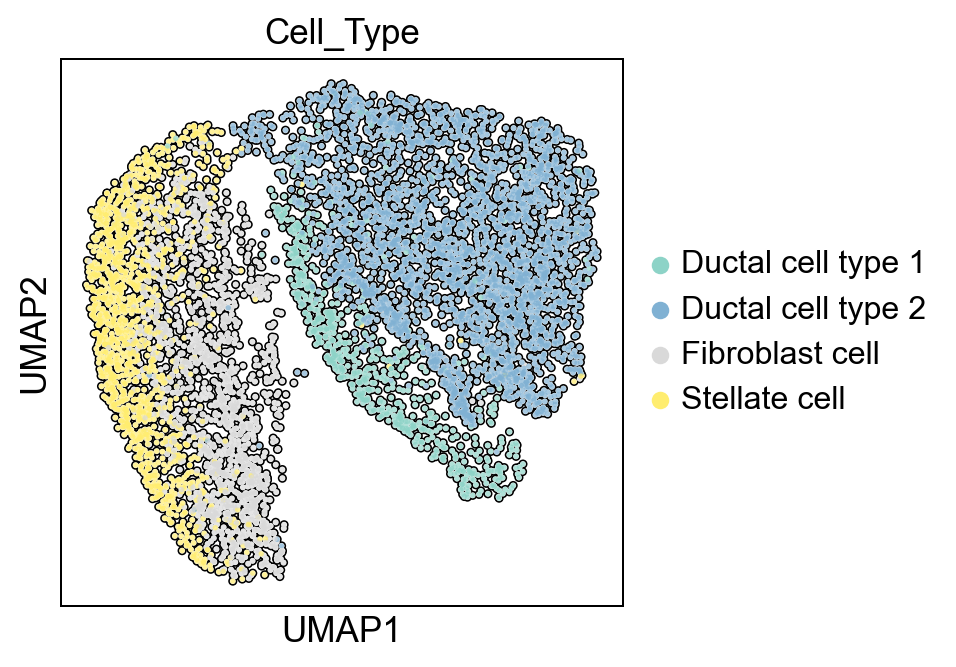

In [43]:
sc.set_figure_params(dpi=90)
pyther.pl.umap(adata_PA,color="Cell_Type", palette="Set3", add_outline=True)

Find the regulatory proteins that were predicted to be most active for each cell type by integrating the NES of each regulatory protein across all cells of a given cell type using the Stouffer's method: $$ NES^C_j = \frac{\sum_{k \in C}NES_{k,j}}{\sqrt{n^C}} $$ where $NES^C_j$ denotes the integrated NES for regulator $j$ in cluster/cell type $C$, $NES_{k,j}$ is the NES of regulator $j$ in cluster/cell type $C$ and $n^C$ is the number of cells in cluster $C$.

In [73]:
NES_integrated = pyther.compute_cluster_stouffer_anndata(adata_PA, "Cell_Type") # Stouffer integration 

Analogously, `compute_cluster_stouffer`, can be used to perform the same operations in Pandas DataFrames. Remove ribosomal proteins from the above matrix (ribosomal protein genes are among the most highly expressed genes in most cell types).

In [103]:
filtered_proteins = NES_integrated.var_names[~NES_integrated.var_names.str.startswith('RP')].to_list() # Exclude columns starting with 'RP' from integrated matrix
NES_integrated = NES_integrated[:,filtered_proteins] # remove ribosomal proteins from the AnnData object

Extract the 5 most activated regulatory protein in each cell population

In [133]:
active_proteins = NES_integrated.to_df().apply(lambda row: row.nlargest(5).index.tolist(), axis=1)  # the top 5 most activated proteins in each cell type
active_proteins

Ductal cell type 1         [NPM1, BTF3, EEF1D, PEBP1, EEF2]
Ductal cell type 2    [KRT19, S100A16, S100A6, CLIC1, TSPO]
Fibroblast cell             [EEF2, HSPA5, NPM1, ARF4, CD99]
Stellate cell               [NPM1, EEF2, CLTA, PFN1, EEF1D]
dtype: object

Show the top activated proteins on a heatmap

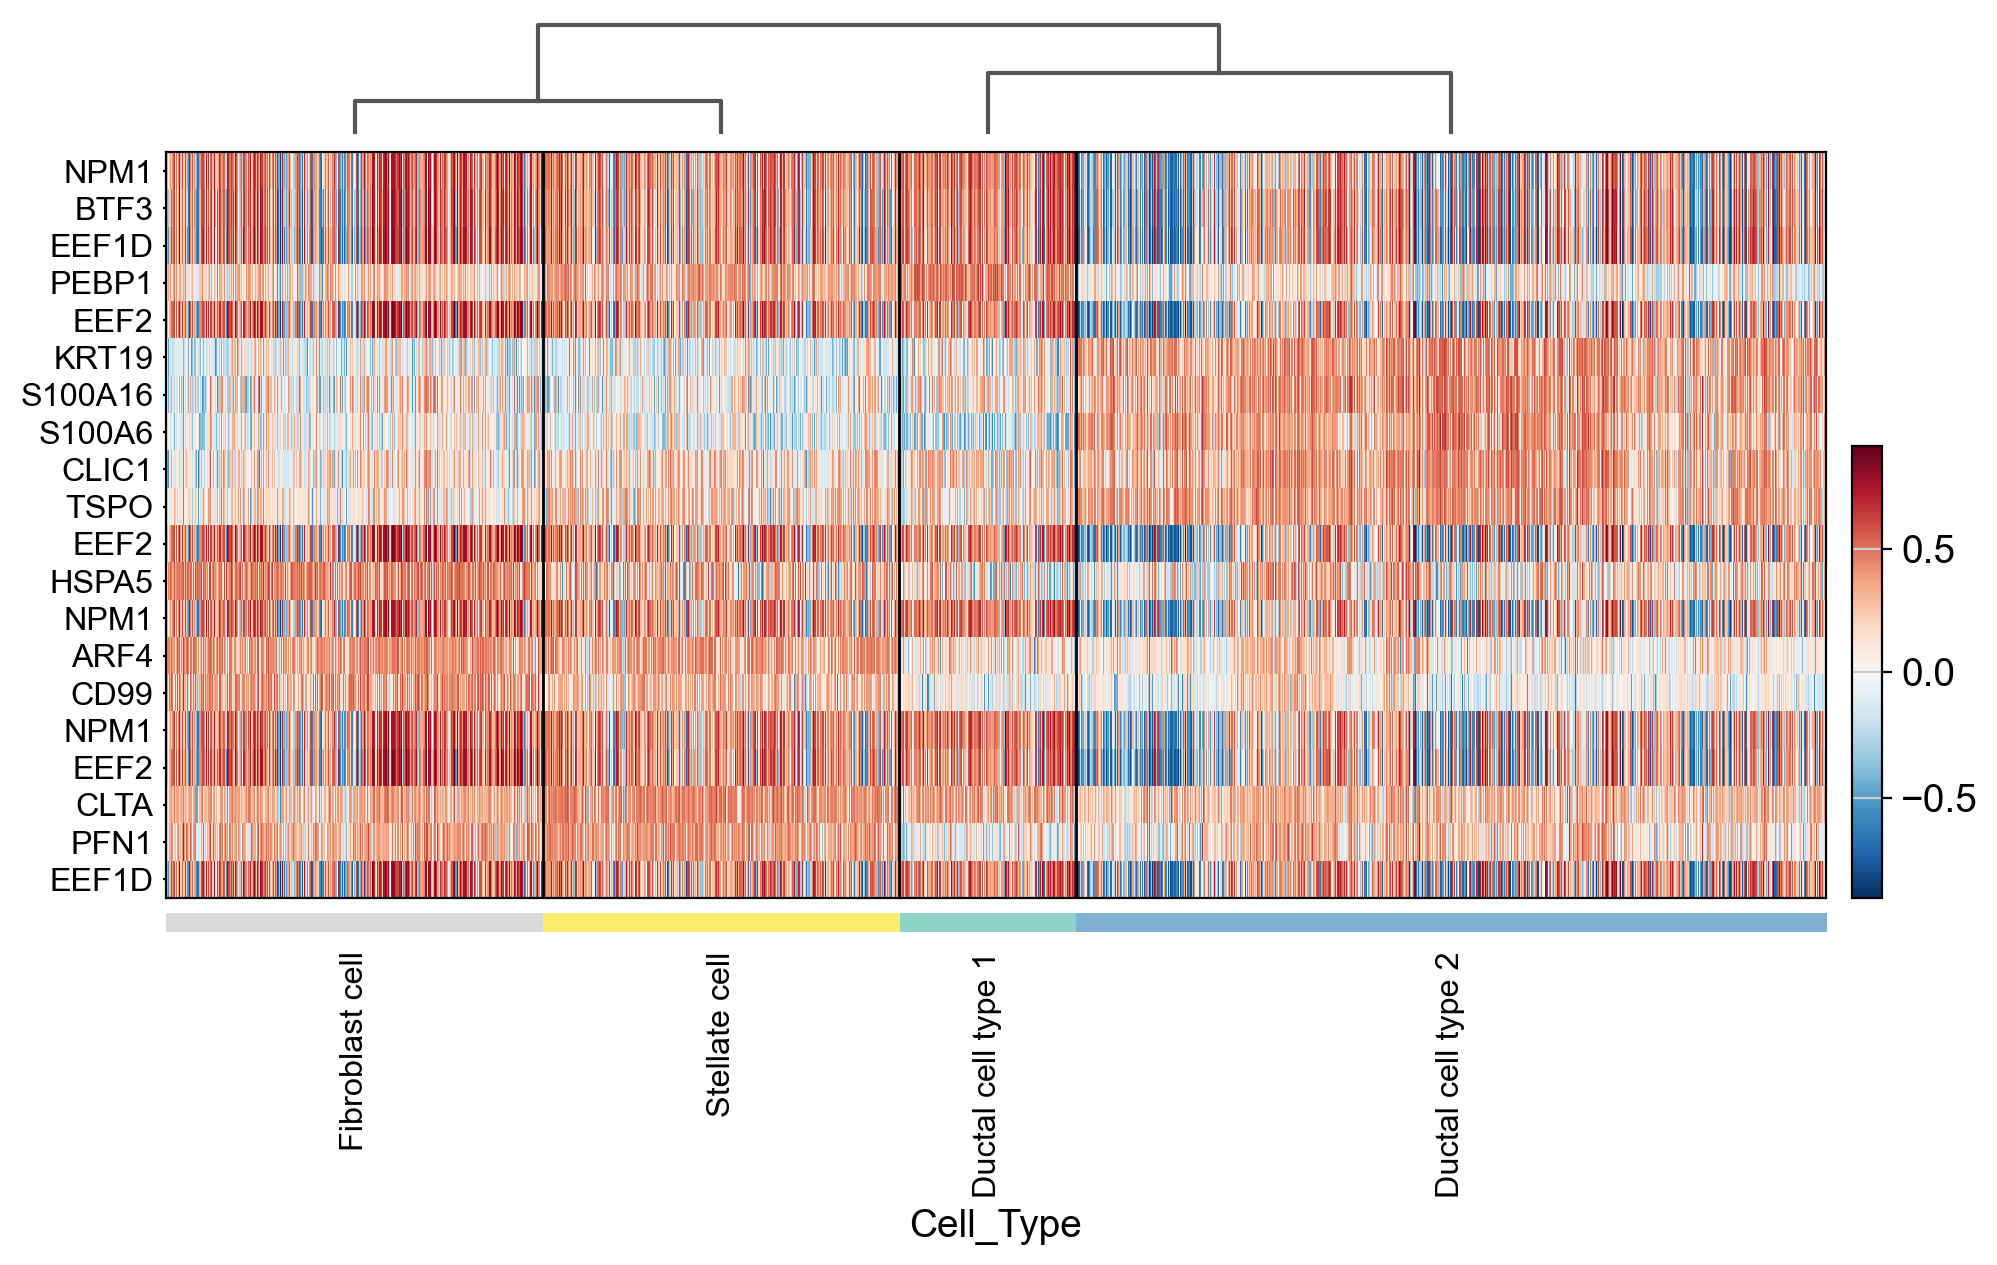

In [202]:
protein_set = active_proteins.sum() # protein set to display on the heatmap
ax = pyther.pl.heatmap(adata_PA, var_names=protein_set, groupby="Cell_Type", layer="pes",vcenter=0,cmap="RdBu_r",dendrogram=True,swap_axes=True,figsize=(11,6))

/Users/lucazanella7/mambaforge/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


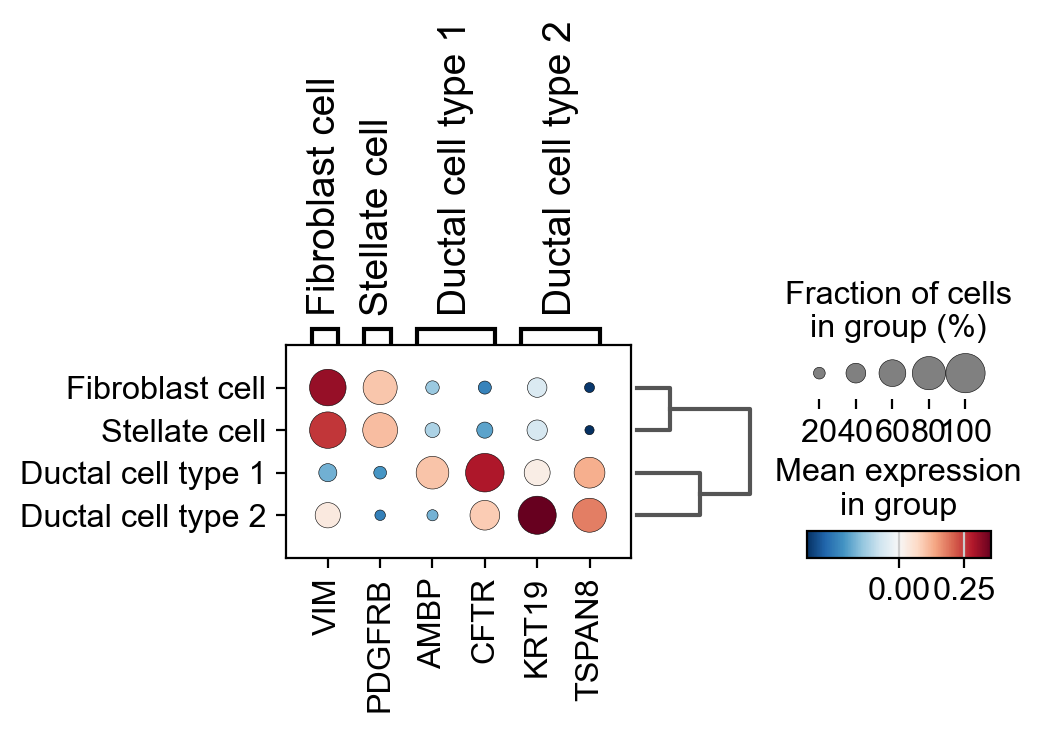

In [172]:
protein_markers_dict = {
    'Ductal cell type 1': ['AMBP', 'CFTR'],
    'Ductal cell type 2': ['KRT19', 'TSPAN8'],
    'Fibroblast cell': ['VIM'],
    'Stellate cell': ['PDGFRB']
}
sc.set_figure_params(dpi=100)
pyther.pl.dotplot(adata_PA, var_names=protein_markers_dict, layer="pes",groupby='Cell_Type', cmap="RdBu_r", vcenter=0,dendrogram=True)

Show how to use <span style="color:green">pyther.config.set_regulators_species_to_use(species="human")</span>


In [7]:
s_net_path = "/Users/lucazanella7/Desktop/ColumbiaProjects/pyther_test_data/subset_Peng/pruned_Stellate.tsv" # path to ARACNe network for stellate
stellate_net = pyther.Interactome('stellate',net_table=s_net_path) # load interactome from stellate cells

In [12]:
stellate_net_ensembl = stellate_net.translate_targets(desired_format="human_ensembl")

IndexError: index 18190 is out of bounds for axis 0 with size 18190